# **PLEASE MAKE YOUR OWN COPY BEFORE EDITING**

# Setup environment

###Load TokaMaker and helpful python packages
In this code segment, we import several helpful python packages and load in the TokaMaker code from GitHub. Default plotting values are also set here to make things more legible on most platforms. We also define a resize_polygon function which is helpful for defining geometries later on. **You do not need to change this code.**

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

In [2]:
# Get the home directory dynamically
home_dir = os.path.expanduser("~")

# Construct the path dynamically
oft_root_path = os.path.join(home_dir, "OpenFUSIONToolkit/install_release")

# Set the environment variable
os.environ["OFT_ROOTPATH"] = oft_root_path

# Append to sys.path
tokamaker_python_path = os.getenv("OFT_ROOTPATH")
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path, "python"))


In [3]:
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh, load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_power_flux_fun

In [4]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

# Setup device geometry
First, we need to tell TokaMaker what our tokamak should look like!

### Set mesh resolution
TokaMaker solves the Grad-Shafranov equation on a computational mesh. The finer the mesh is, the more accurate the solution will be. However, a finer mesh also decreases the speed of the solver. Here, we set a default resolution for the mesh in each domain. **You do not need to change these values.**

In [5]:
#### DO NOT CHANGE ####
plasma_dx = 0.15
coil_dx = 0.15
vv_dx = 0.15
vac_dx = 0.25
#### DO NOT CHANGE ####

### Specify the geometry of the vacuum vessel

We need to decide on the shape of our vacuum vessel. We want to design a vacuum vessel that will fit our desired plasma shape. To visualize what our plasma looks like, we can use several quantities on your list of targets, including major radius, minor radius, elongation, and triangularity. Modify these quantities to correspond to your targets



In [6]:
major_radius = 4.55
minor_radius = 1.2
elongation = 1.4
triangularity =  -0.5

boundary_pts = create_isoflux(30,major_radius,0.0,minor_radius,elongation,triangularity)

Now, we have to decide the shape of our vacuum vessel cross-section. We do this by defining an array of (R,Z) coordinates for the vacuum vessel boundary. Every number in the array must be a float (a number including a decimal point). So, 3.5 and 3.0 are acceptable entries, but 3 is not.

In [7]:
vv_boundary = np.array([[3.25, -0.75],[3.75, -1.25], [4.5, -1.85],[6.0, -1.85], [6.0, 1.85], [4.5, 1.85], [3.75, 1.25], [3.25, 1.0]]) ##Add/change the vacuum vessel coordinates here!!!

vv_outer = resize_polygon(vv_boundary, 0.04)

Now, you can plot the shape of the plasma and the vacuum vessel boundary to see what they look like.  If your plasma cross-section does not fit inside the vacuum vessel, go back and modify your vacuum vessel points!

Text(0, 0.5, 'Z (m)')

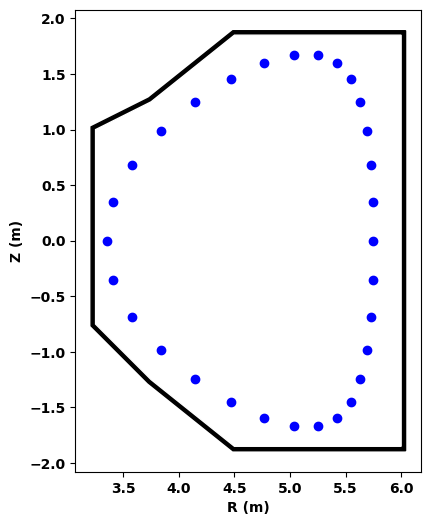

In [8]:
fig, ax = plt.subplots()
ax.fill(vv_outer[:,0], vv_outer[:,1], color = 'k')
ax.fill(vv_boundary[:,0], vv_boundary[:,1], color = 'w')
ax.scatter(boundary_pts[:,0], boundary_pts[:,1], color = 'b')
ax.set_aspect(aspect = 1)
ax.set_xlabel('R (m)')
ax.set_ylabel('Z (m)')

### Place poloidal field coils
Now, we need to specify the locations of our poloidal field coils using (R,Z) coordinates. You can use a total of 8 poloidal field coils. You will need to change these coordinates to achieve the desired plasma shape.

In [9]:
PF_1_R = 4.0
PF_1_Z = 2.0

PF_2_R = 4.0
PF_2_Z = -2.0

PF_3_R = 5.25
PF_3_Z = 2.25

PF_4_R = 5.25
PF_4_Z = -2.25

PF_5_R = 6.5
PF_5_Z = .5

PF_6_R = 6.5
PF_6_Z = -.5

PF_7_R = 3
PF_7_Z = 0.25

PF_8_R = 3
PF_8_Z = -0.25

coil_locs = np.array([[PF_1_R, PF_1_Z], [PF_2_R, PF_2_Z], [PF_3_R, PF_3_Z], [PF_4_R, PF_4_Z], [PF_5_R, PF_5_Z], [PF_6_R, PF_6_Z], [PF_7_R, PF_7_Z], [PF_8_R, PF_8_Z]])

We can plot the locations of our coils and the vacuum vessel boundary. Make sure that the coils are outside of the vacuum vessel.

Text(0, 0.5, 'Z (m)')

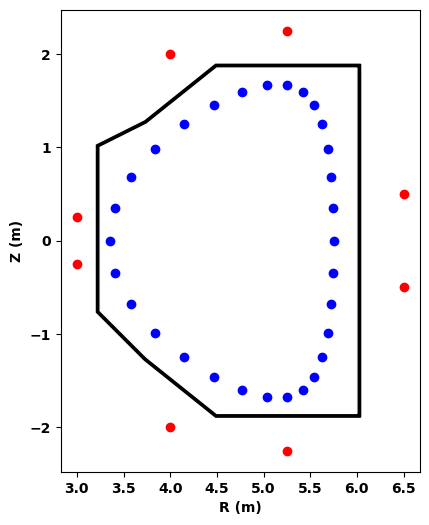

In [10]:
fig, ax = plt.subplots()
ax.fill(vv_outer[:,0], vv_outer[:,1], color = 'k')
ax.fill(vv_boundary[:,0], vv_boundary[:,1], color = 'w')
ax.scatter(boundary_pts[:,0], boundary_pts[:,1], color = 'b')
ax.scatter(coil_locs[:,0], coil_locs[:,1], color = 'r')
ax.set_aspect(aspect = 1)
ax.set_xlabel('R (m)')
ax.set_ylabel('Z (m)')

### Define the regions of our tokamak
We have to tell the solver what domains we plan on implementing in our tokamak. For this device, we implement four types of domains:
1.   An air domain, which surrounds the tokamak
2.   A vaccum vessel domain, for the vacuum vessel containing the plasma
3.   A plasma domain, where the plasma will be located
4.   Eight poloidal field coil domains, which contain the coils we will use to shape the plasma

**You do not need to change this code.**



In [11]:
#### DO NOT CHANGE ####
# Create a mesh object
mesh = gs_Domain()
# Define region information for mesh
mesh.define_region('air',vac_dx,'boundary')        # Air domain
mesh.define_region('vv',vv_dx,'conductor',eta= 6.9E-7)      # Vaccum vessel domain
mesh.define_region('plasma',plasma_dx,'plasma')    # Plasma domain
# Define each of the PF coils
for i in range(1,9):
    mesh.define_region('PF_' + str(i),coil_dx,'coil') # Coil domains
#### DO NOT CHANGE ####

## Add region boundaries to our gs_Domain object
Now that we have decided on our geometry, we need to pass that information on to the mesh object. **You do not need to modify this code.**

In [12]:
#### DO NOT CHANGE ####
# Define geometry
mesh.add_annulus(vv_boundary,'plasma',vv_outer,'vv',parent_name='air') # Define the shape of the VV

# Define the shape of the PF coils
for i in range(1,9):
    mesh.add_rectangle(coil_locs[i-1,0],coil_locs[i-1,1],0.3,0.3,'PF_' + str(i),parent_name='air')
#### DO NOT CHANGE ####

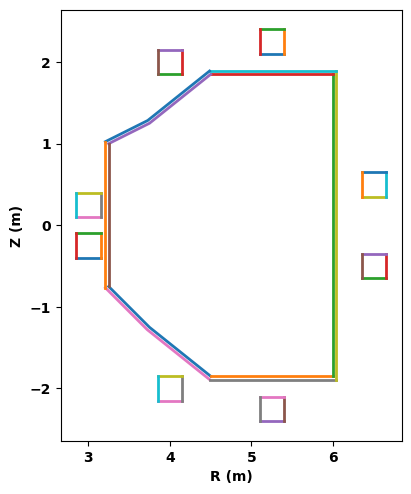

In [13]:
fig, ax = plt.subplots(1,1,figsize=(4,6),constrained_layout=True)
mesh.plot_topology(fig,ax)

### Generate mesh
Now we generate the actual mesh that TokaMaker will use to solve the Grad Shafranov equation. We also plot the mesh to make sure that each region is defined properly. **You do not need to change this code.**

In [14]:
#### DO NOT CHANGE ####
mesh_pts, mesh_lc, mesh_reg = mesh.build_mesh()
coil_dict = mesh.get_coils()
cond_dict = mesh.get_conductors()
#### DO NOT CHANGE ####

Assembling regions:
  # of unique points    = 313
  # of unique segments  = 48
Generating mesh:
  # of points  = 1788
  # of cells   = 3466
  # of regions = 11


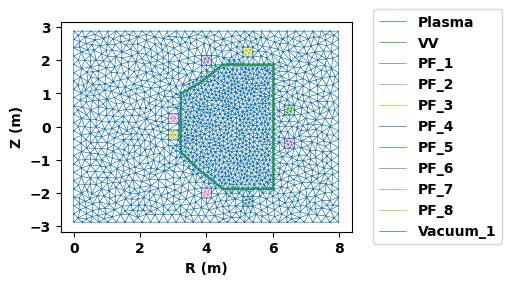

In [15]:
fig, ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
mesh.plot_mesh(fig,ax)

# Find a plasma equilibrium

### Setup TokaMaker
Now that we have set up our device, we are ready to solve for an equilibrium. First, we need to make a new object of the TokaMaker class and load in our mesh information.

**Important note:** Without resetting your tokamaker object, these code segments can only be run once per Google colab session.  If you have modified your device and would like to run these lines again, please uncomment the "tokamaker.reset()" line, which will allow you to run tokamaker.setup() again. If you accidentally run these cells again without running reset(), you may get a message that your kernel has crashed. You can go to 'Runtime' -> 'Restart Session' in the Google Colab menu to start a new session (all of your code will be saved).

In [16]:
# tokamaker.reset()

In [17]:
#### DO NOT CHANGE ####
myOFT = OFT_env(nthreads=2)
tokamaker = TokaMaker(myOFT)
tokamaker.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
tokamaker.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
#### DO NOT CHANGE ####

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          f8ced65
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/z5/d2ytmy3d2h18qcqwb9v71w2m0000gq/T/oft_88630/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.596E+01
    # of points  =    1788
    # of edges   =    5253
    # of cells   =    3466
    # of boundary points =     108
    # of boundary edges  =     108
    # of boundary cells  =     108
  Resolution statistics:
    hmin =  4.000E-02
    hrms =  1.855E-01
    hmax =  3.716E-01
  Surface grounded at vertex     303



### Set magnetic field and major radius

Here, we specify the magnetic field and major radius of the plasma. You should change these values to match your target parameters.

In [18]:
B0 = 1 #toroidal magnetic field
R0 = 3 #major radius

tokamaker.setup(order=2,F0=B0*R0)


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.9000000000000000E-003


### Define global quantities and targets

We need to tell the solver a bit more information about our device. First, we need to specify the total current in the plasma, by setting a target value for 'Ip'.

We also need to specify a target for the plasma pressure in the core of the tokamak. To do this, we set a number for the 'p_core_target'.

You will likely need to adjust these quantities to match other design targets, such as an appropriate q-profile and the correct poloidal beta ($\beta_p$).

In [19]:
Ip_target = 3E6
p_core_target = 8.0E4

tokamaker.set_targets(Ip=Ip_target,pax = p_core_target)

### Define plasma profiles

The magnitudes of the F*F' and P' profiles are determined by the global quantities set above.  Now, we need to specify the actual shape of the profiles. For simplicity, we will use simple polynomial profiles of the form
 $((1-\hat{\psi})^{\alpha})^{\gamma}$ using the built-in TokaMaker function 'create_power_flux_fun'.

 Feel free to adjust the alpha ($\alpha$) and gamma ($\gamma$) parameters for both P' and F*F' to reach your desired internal inductance ($l_i$) target.


In [20]:
ffp_alpha = 4.0
ffp_gamma = 1.0

pp_alpha = 1.5
pp_gamma = 2.0

ffp_prof = create_power_flux_fun(40,ffp_alpha,ffp_gamma)
pp_prof = create_power_flux_fun(40,pp_alpha,pp_gamma)

tokamaker.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

Now, we can visualize our profiles. "Peaked" profiles, which are more concentrated around $\Psi$ = 0, correspond to higher internal inductance ($l_i$).

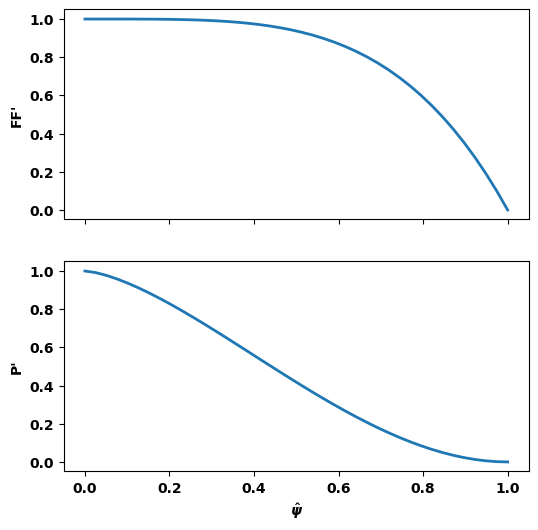

In [21]:
fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

### Set shape targets

Now we need to tell TokaMaker what the shape of our plasma cross-section will look like. Given that we've already made an array of points defining our plasma, we just need to pass this array to the set_isoflux() method. **You do not need to change this code**.

In [22]:
tokamaker.set_isoflux(boundary_pts, weights = 5*np.ones(len(boundary_pts)))

### Set up coil regularization

This code segment makes sure that the solver tries to minimize the currents in each coil. **You should not change this code**

In [23]:
#### DO NOT CHANGE ####
coil_regmat = np.zeros((tokamaker.ncoils+1,tokamaker.ncoils+1), dtype=np.float64)
coil_regmat = np.eye(tokamaker.ncoils+1, dtype = np.float64)
targets = np.zeros(tokamaker.ncoils+1)
weights = 0.1*np.ones(tokamaker.ncoils+1)
tokamaker.set_coil_reg(coil_regmat, targets, weights)
#### DO NOT CHANGE ####

Now we are ready to solve. **You shouldn't have to edit any of this code.**

In [24]:
#### DO NOT CHANGE ####
tokamaker.init_psi(major_radius,0.0,minor_radius,elongation,triangularity)
err_flag = tokamaker.solve()
#### DO NOT CHANGE ####

Starting non-linear GS solver
     1  1.2682E+00  2.2576E-01  4.4172E-02  4.7785E+00  3.8561E-04 -0.0000E+00
     2  4.4421E+00  1.2070E-01  8.0590E-03  4.7545E+00  4.3379E-04 -0.0000E+00
     3  4.5536E+00  1.2148E-01  3.4430E-03  4.7442E+00  3.4350E-04 -0.0000E+00
     4  4.6554E+00  1.2089E-01  1.6795E-03  4.7394E+00  3.0095E-04 -0.0000E+00
     5  4.7155E+00  1.2043E-01  8.5088E-04  4.7371E+00  2.8032E-04 -0.0000E+00
     6  4.7479E+00  1.2016E-01  4.3544E-04  4.7359E+00  2.7047E-04 -0.0000E+00
     7  4.7650E+00  1.2002E-01  2.2340E-04  4.7353E+00  2.6584E-04 -0.0000E+00
     8  4.7738E+00  1.1995E-01  1.1495E-04  4.7350E+00  2.6370E-04 -0.0000E+00
     9  4.7784E+00  1.1991E-01  5.9276E-05  4.7349E+00  2.6269E-04 -0.0000E+00
    10  4.7808E+00  1.1989E-01  3.0596E-05  4.7348E+00  2.6221E-04 -0.0000E+00
    11  4.7820E+00  1.1988E-01  1.5788E-05  4.7348E+00  2.6198E-04 -0.0000E+00
    12  4.7827E+00  1.1988E-01  8.1469E-06  4.7348E+00  2.6186E-04 -0.0000E+00
    13  4.7830E+00  1.

### Check for convergence
This code prints out err_flag. If it is anything other than 0, the solver has failed.

In [25]:
print(err_flag)

None


# Analyze equilibrium

Now we are ready to analyze our equilibrium and check how it performs against our desired metrics.

### Plot equilibrium solution

The red crosses correspond to our target plasma boundary. Check if this lines up with the actual plasma boundary. If they are not similar, you may need to adjust your coil positions to create your desired shape.

**You do not need to change this code.**


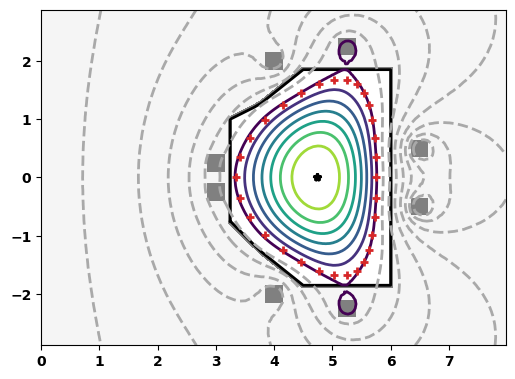

In [26]:
#### DO NOT CHANGE ####
fig, ax = plt.subplots()
tokamaker.plot_machine(fig,ax)
tokamaker.plot_psi(fig,ax)
tokamaker.plot_constraints(fig,ax)
#### DO NOT CHANGE ####

### Print equilibrium statistics

TokaMaker has a built-in function to compute a bunch of relevant quantities for an equilibrium. There are a few things you should take note of:

1.   Where is the current centroid? Is it close to your desired major radius? If not, you may need to adjust your coil positions to better match the target shape. (Cell 9)
2.   What is the elongation? Is it close to your target elongation? If not, you may need to adjust your coil positions to better match the target shape. (Cell 9)
3.   What is the triangularity. Is it close to the target triangularity? If not, you may need to adjust your coil positions to better match the target shape. (Cell 9)
4.   What is your q_95? Is it less than 2.5? If so, you may need to decrease your target plasma current (Ip) to increase this number.  Is it way above 4? If so, you may want to increase your plasma current to decrease this number. (Cell 19)
5. What is your beta_pol? Is it close to your target beta_pol? If not, you might need to adjust your p_core_target. (Cell 19)
6. What is your internal inductance(l_i) ? Is it close to your target l_i? If not, you may need to alter the alpha and gamma factors in your FF' and P' profile shapes to alter this number. (Cell 20)



In [27]:
tokamaker.print_info()

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    3.0000E+06
  Current Centroid [m]    =    4.669  0.000
  Magnetic Axis [m]       =    4.735  0.000
  Elongation              =    1.488 (U:  1.488, L:  1.489)
  Triangularity           =   -0.532 (U: -0.533, L: -0.532)
  Plasma Volume [m^3]     =   188.181
  q_0, q_95               =    0.346  0.554
  Peak Pressure [Pa]      =    7.9822E+04
  Stored Energy [J]       =    5.2292E+06
  <Beta_pol> [%]          =   29.0712
  <Beta_tor> [%]          =   10.7105
  <Beta_n>   [%]          =    2.8407
  Diamagnetic flux [Wb]   =    5.1346E-01
  Toroidal flux [Wb]      =    4.6608E+00
  l_i                     =    0.8688


We can also save all of this equilibrium information in a python dictionary, so we can access it later if needed.

In [28]:
eq_info = tokamaker.get_stats()
print(eq_info.keys())
print(eq_info["beta_n"])
print(eq_info["beta_pol"])
print(eq_info["beta_tor"])

dict_keys(['Ip', 'Ip_centroid', 'kappa', 'kappaU', 'kappaL', 'delta', 'deltaU', 'deltaL', 'R_geo', 'a_geo', 'vol', 'q_0', 'q_95', 'P_ax', 'W_MHD', 'beta_pol', 'dflux', 'tflux', 'l_i', 'beta_tor', 'beta_n'])
2.840677274971479
29.071184655134953
10.710511442739659


### Plot coil currents

For our device to be efficient, we want the currents in our poloidal field coils to be low. Here, we check if our poloidal field coil currents are more than two times the plasma current by plotting our coil currents and the current limit (dashed red line).

If any coil has current greater than two times the plasma current, try to adjust your coil positions to reduce their currents. Some things to try:


*   Move your coils closer to the plasma (this may require modifying your vacuum vessel)
*   Move your coils apart from one another, so they don't have to compete



{'PF_1': -499541.5590120326, 'PF_2': -499640.3216891414, 'PF_3': 319359.35342040606, 'PF_4': 319998.7265802332, 'PF_5': -584088.2324682856, 'PF_6': -583715.5738215299, 'PF_7': 108130.46171373181, 'PF_8': 108371.82988602963}


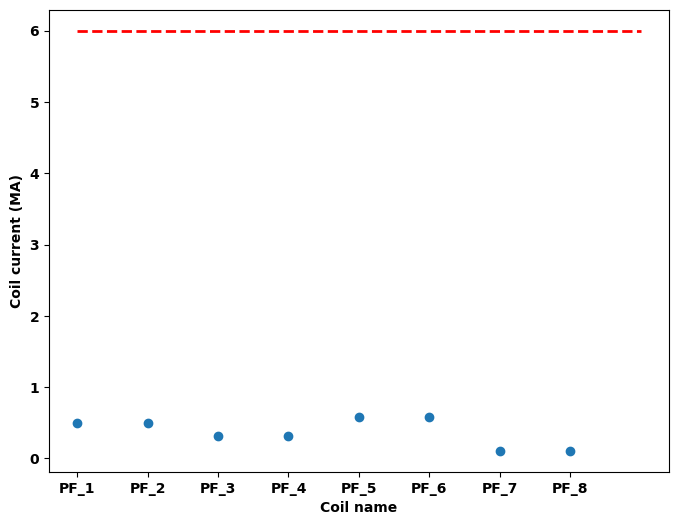

In [29]:
fig,ax = plt.subplots(figsize = (8,6))

coil_currents, current_map = tokamaker.get_coil_currents()

for i, key in enumerate(coil_dict.keys()):
    ax.scatter(key, np.abs(coil_currents[key] / 1E6), color='tab:blue')

coil_current_limit = eq_info['Ip']*2
ax.hlines(coil_current_limit/1E6, xmin = 0, xmax = len(coil_dict.keys()), color = 'r', linestyle = '--')

ax.set_xlabel('Coil name')
ax.set_ylabel('Coil current (MA)')

print(coil_currents)

### Check vertical stability

Plasmas in tokamaks with elongation greater than 1 can be susceptible to a "vertical instability", where the plasma moves up or down within the vacuum vessel at an exponential rate. Here, we check whether the growth rate of our vertical instability is low enough that it can be prevented with a control system.

If the "feedback capability parameter" is greater than 2, modify your vacuum vessel to make it closer to the plasma, because the vaccum vessel can help provide vertical stability.

**You do not need to change this code.**

In [30]:
#### DO NOT CHANGE ####
eig_vals, eig_vecs = tokamaker.eig_td(omega = -1E4, neigs = 10)
growth_rate = -eig_vals[0,0]

eigval_wall, eigvec_wall = tokamaker.eig_wall()
wall_time = 1/eigval_wall[1,0]

feedback_capability_param = growth_rate*wall_time
print('Feedback capability parameter: ' + str(feedback_capability_param))
#### DO NOT CHANGE ####

Feedback capability parameter: 0.7109916597105111


# New 

In [31]:
tokamaker.settings.pm=False
tokamaker.update_settings()

In [32]:
growth = []
beta_p = []
modes = []
zhist = []
beta_scale = 1.0

for beta_target in np.linspace(0.01,0.8,10): # how do you find the range 
    print('Computing Beta_approx [%] {0:.2f}'.format(beta_target*100.0))
    # Compute new equilibrium
    tokamaker.init_psi(major_radius,0.0,minor_radius,elongation,triangularity)
    beta_approx = beta_target*beta_scale
    
    for i in range(4):
        tokamaker.set_targets(Ip=Ip_target,Ip_ratio=(1.0/beta_approx - 1.0))
        tokamaker.solve()
        beta_approx *= beta_target/tokamaker.get_stats()['beta_pol']*100.0
    beta_scale = beta_approx/beta_target
    beta_p.append(tokamaker.get_stats()['beta_pol'])
    print('  Actual Beta_p = {0:.2f}'.format(beta_p[-1]))
    psi0 = tokamaker.get_psi(False)
    # Compute linear stability
    eig_vals, eig_vecs = tokamaker.eig_td(-1.E5,10,False)
    eig_sign = eig_vecs[0,tokamaker.r[:,1]>0.0][abs(eig_vecs[0,tokamaker.r[:,1]>0.0]).argmax()]
    modes.append(eig_vecs[0,:]*eig_sign)
    growth.append(eig_vals[0,0])
    # Compute nonlinear evolution
    psi_ic = psi0-0.01*eig_vecs[0,:]*(tokamaker.psi_bounds[1]-tokamaker.psi_bounds[0])/eig_sign
    tokamaker.set_psi(psi_ic)
    dt = 0.2/abs(eig_vals[0,0])
    tokamaker.setup_td(dt,1.E-13,1.E-11)
    sim_time = 0.0
    results = []
    z0 = [[sim_time,tokamaker.o_point[1]],]
    for i in range(30):
        sim_time, _, nl_its, lin_its, nretry = tokamaker.step_td(sim_time,dt)
        assert nretry >= 0
        z0.append([sim_time,tokamaker.o_point[1]])
        results.append(tokamaker.get_psi())
    zhist.append(z0)

Computing Beta_approx [%] 1.00
  Actual Beta_p = 1.00
Computing Beta_approx [%] 9.78
  Actual Beta_p = 9.79
Computing Beta_approx [%] 18.56
  Actual Beta_p = 18.53
Computing Beta_approx [%] 27.33
  Actual Beta_p = 27.28
Computing Beta_approx [%] 36.11
  Actual Beta_p = 36.11
Computing Beta_approx [%] 44.89
  Actual Beta_p = 44.84
Computing Beta_approx [%] 53.67
  Actual Beta_p = 53.56
Computing Beta_approx [%] 62.44
  Actual Beta_p = 62.24
Computing Beta_approx [%] 71.22
  Actual Beta_p = 71.15
Computing Beta_approx [%] 80.00
  Actual Beta_p = 79.92


In [33]:
'''
Ip_target = 3E6
p_core_target = 8.0E4

tokamaker.set_targets(Ip=Ip_target,pax = p_core_target)
pressures = np.linspace(1.0E4, 1.0E5, 10)
for pressure in pressures: 
    tokamaker.set_targets(Ip = Ip_target, pax = pressure)
    tokamaker.solve()
    # get the info, 
    eig_vals, eig_vecs = tokamaker.eig_td(-1.E5,10,False)
    eig_sign = eig_vecs[0,tokamaker.r[:,1]>0.0][abs(eig_vecs[0,tokamaker.r[:,1]>0.0]).argmax()]
    modes.append(eig_vecs[0,:]*eig_sign)
    growth.append(eig_vals[0,0])

# plot growth versus pressure 
plt.plot(pressures, growth)

'''

'\nIp_target = 3E6\np_core_target = 8.0E4\n\ntokamaker.set_targets(Ip=Ip_target,pax = p_core_target)\npressures = np.linspace(1.0E4, 1.0E5, 10)\nfor pressure in pressures: \n    tokamaker.set_targets(Ip = Ip_target, pax = pressure)\n    tokamaker.solve()\n    # get the info, \n    eig_vals, eig_vecs = tokamaker.eig_td(-1.E5,10,False)\n    eig_sign = eig_vecs[0,tokamaker.r[:,1]>0.0][abs(eig_vecs[0,tokamaker.r[:,1]>0.0]).argmax()]\n    modes.append(eig_vecs[0,:]*eig_sign)\n    growth.append(eig_vals[0,0])\n\n# plot growth versus pressure \nplt.plot(pressures, growth)\n\n'

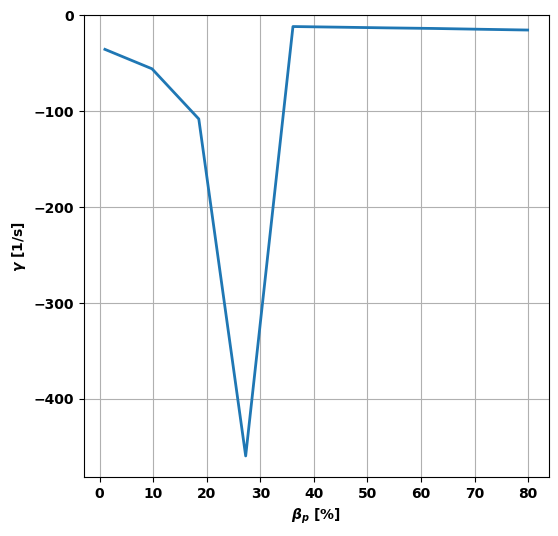

In [34]:
fig, ax = plt.subplots(1,1)
ax.plot(beta_p,growth)
ax.set_ylim(top=0.0)
ax.grid(True)
ax.set_ylabel(r'$\gamma$ [1/s]')
_ = ax.set_xlabel(r'$\beta_p$ [%]')

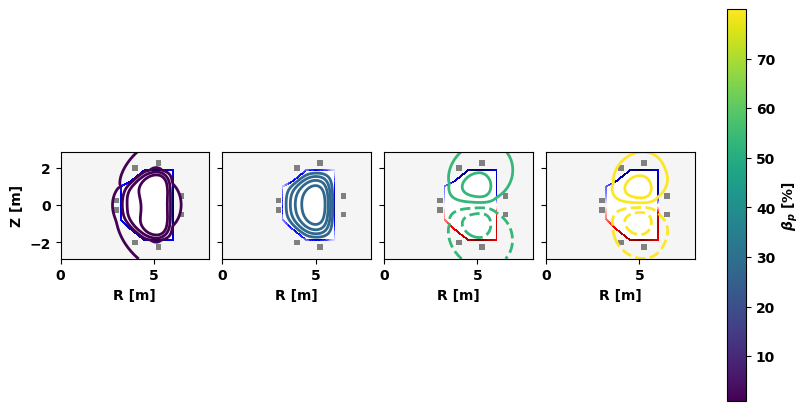

In [35]:
norm = mpl.colors.Normalize(vmin=beta_p[0], vmax=beta_p[-1])
scalarMap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)

fig, ax = plt.subplots(1,4,sharey=True,constrained_layout=True,figsize=(8,4))
for ax_tmp in ax:
    tokamaker.plot_machine(fig,ax_tmp,limiter_color=None)
for j, i in enumerate((0,3,6,9)):
    colorVal = scalarMap.to_rgba(beta_p[i])
    tokamaker.plot_psi(fig,ax[j],psi=modes[i],plasma_nlevels=6,normalized=False,plasma_color=[colorVal],opoint_color=None,xpoint_color=None,vacuum_nlevels=0)
    tokamaker.plot_eddy(fig,ax[j],dpsi_dt=modes[i]*abs(growth[i]),colormap='seismic',symmap=True,clabel=None)
for ax_tmp in ax:
    ax_tmp.set_xlabel(r'R [m]')
ax[0].set_ylabel(r'Z [m]')
_ = fig.colorbar(scalarMap,ax=ax[:],label=r'$\beta_p$ [%]')

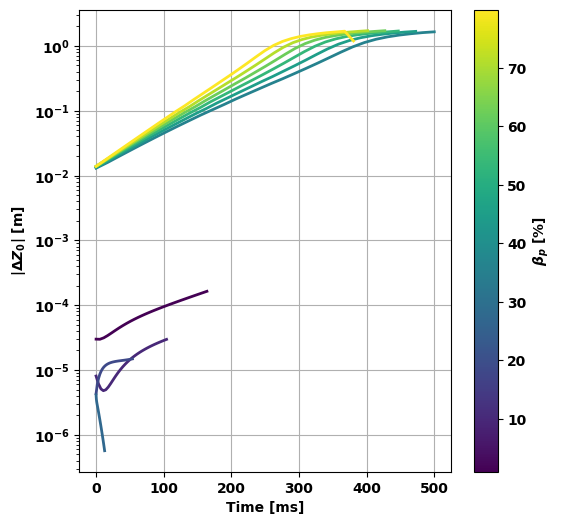

In [36]:
fig, ax = plt.subplots(1,1)
for i, z0 in enumerate(zhist):
    z_hist = np.asarray(z0); z_hist = z_hist[1:,:] - [z_hist[1,0], z_hist[0,1]]
    colorVal = scalarMap.to_rgba(beta_p[i])
    ax.semilogy(z_hist[:,0]*1.E3,abs(z_hist[:,1]),color=colorVal)
ax.grid(True)
ax.set_ylabel(r'$|\Delta Z_0|$ [m]')
ax.set_xlabel(r'Time [ms]')
_ = fig.colorbar(scalarMap,ax=ax,label=r'$\beta_p$ [%]')